In [1]:
import pandas as pd
import datetime as dt
import os
from datetime import datetime, date, timedelta
import warnings
import re
import pymysql
from sqlalchemy import create_engine
import yaml
import numpy as np
import logging
import pickle
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

#from sklearn.metrics import mean_squared_error
import csv
import random
#from concurrent.futures import ProcessPoolExecutor

# Configuración de logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)



# Cambia al directorio del script
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


from sql_queries import *

# Define una funcion para cargar la configuración desde el archivo YAML
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

# Cargar la configuración
config = load_config('config.yaml')

db_config_pre = config['database_pre']
db_name_pre = db_config_pre['name']
db_host_pre = db_config_pre['host']
db_user_pre = db_config_pre['user']
db_password_pre = db_config_pre['password']

db_config_pro = config['database_pro']
db_name_pro = db_config_pro['name']
db_host_pro = db_config_pro['host']
db_user_pro = db_config_pro['user']
db_password_pro = db_config_pro['password']

# Asignar las variables como constantes
#db_config = config['database']
#db_name = db_config['name']

db_tables = config['tables']
table_dim_id_market = db_tables['table_dim_id_market']
table_dim_id_pais = db_tables['table_dim_id_pais']
table_id_tickers = db_tables['table_id_tickers']
table_process_daily = db_tables['table_process_daily']
table_raw_stock = db_tables['table_raw_stock']
table_raw_fundamentals = db_tables['table_raw_fundamentals']
table_predictions_stock_daily = db_tables['table_predictions_stock_daily']
table_orders_stock_market = db_tables["table_orders_stock_market"]

models = config['models']
file_model_dir = models['model_dir']
file_model_max = models['model_max']
file_model_min = models['model_min']

#logfile_path = config.get('logfile_path')
log_level = config.get('log_level', 'INFO')  # Default to 'INFO' if not specified


config_pymysql_pro= {
    'host': db_host_pro,
    'user': db_user_pro,
    'password': db_password_pro,
    'database': db_name_pro
}


# Definición de las funciones
def function_exponential_min(x, a, b, c):
    return a * np.exp(-b * x) + c

def function_exponential_max(x, a, b, c):
    return a * np.exp(b * x) + c

def function_logaritmic_max(x, max_x, b):
    return np.log(b * x + 1) / np.log(b * max_x + 1)

def function_logaritmic_min(x, max_x, b):
    return -np.log(b * x + 1) / np.log(b * max_x + 1)
    
def treat_null_values_1(df):
    # Eliminar la columna 'capitalizacion_millones'
    if 'capitalizacion_millones' in df.columns:
        df = df.drop(columns=['capitalizacion_millones'])

    # Eliminar filas con valores nulos en columnas específicas
    drop_na_columns = [
        'float_pct_total_outstdg', 'free_float_eur_millones', 'position_relative'
    ]
    df = df.dropna(subset=drop_na_columns)

    # Sustituir valores nulos por 0 en las columnas especificadas
    fill_zero_columns = [
        'roe_y1_year_actual', 'crecimiento_largo_plazo_percentage',
        'div_yld_y0_year_cerrado', 'div_yld_y1_year_actual', 'div_yld_y2',
        'div_yld_y3', 'per_y0_year_cerrado', 'per_y1_year_actual', 'per_y2',
        'per_y3', 'ev_ebitda_y0_year_cerrado', 'ev_ebitda_y1_year_actual',
        'ev_ebitda_y2', 'ev_ebitda_y3', 'precio_valor_libros_y0_year_cerrado',
        'precio_valor_libros_y1_year_actual', 'precio_valor_libros_y2',
        'precio_valor_libros_y3', 'precio_cf_y0_year_cerrado',
        'precio_cf_y1_year_actual', 'precio_cf_y2', 'precio_cf_y3',
        'fcf_ev_percentage_y0_year_cerrado', 'fcf_ev_percentage_y1_year_actual',
        'fcf_ev_percentage_y2', 'fcf_yld_percentage_y0_year_cerrado',
        'fcf_yld_percentage_y1_year_actual', 'fcf_yld_percentage_y2', 'peg_fy1',
        'peg_fy2', 'margen_ebitda_percentage_y0_year_cerrado',
        'margen_ebitda_percentage_y1_year_actual', 'margen_ebitda_percentage_y2',
        'margen_ebitda_percentage_y3', 'deuda_neta_ebitda_y0_year_cerrado',
        'deuda_neta_ebitda_y1_year_actual', 'deuda_neta_ebitda_y2',
        'deuda_neta_ebitda_y3', 'twelve_meses_percentage', 'ytd_percentage',
        'div_payout_y0_year_cerrado', 'div_payout_y1_year_actual', 'div_payout_y2',
        'div_payout_y3', 'ec_reco_neg', 'three_y_price_volatility',
        'three_y_beta_rel_to_loc_idx', 'bpa_plus_1e_3meses',
        'var_percentage_bpa_plus_1e_3meses', 'ebit_plus_1e_3meses',
        'ebit_plus_1e_actual', 'var_percentage_ebit_plus_1e_3meses',
        'precio_objetivo_3meses', 'var_percentage_po_3meses',
        'ventas_plus_1e_3meses', 'ventas_plus_1e_actual',
        'var_percentage_ventas_plus_1e_3meses',
        'bpa_trimestre_sorpresa_percentage', 'ventas_trimestre_sorpresa_percentage',
        'ebit_trimestral_sorpresa_percentage', 'short_interest_percentage_out',
        'short_interest_acciones_actual', 'short_interest_acciones_3_meses',
        'evolucion_acciones_cortas_3_meses_percentage'
    ]
    df[fill_zero_columns] = df[fill_zero_columns].fillna(0)

    # Sustituir valores nulos por 1 en 'recomendacion_numerica'
    if 'recomendacion_numerica' in df.columns:
        df['recomendacion_numerica'] = df['recomendacion_numerica'].fillna(1)

    return df

def setup_logging(logfile_path, log_level):
    # Crear la carpeta de logs si no existe
    log_dir = os.path.dirname(logfile_path)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Configurar el logging
    logging.basicConfig(
        level=getattr(logging, log_level),
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(logfile_path),
            logging.StreamHandler()
        ]
    )

In [2]:
df_metadata = pd.read_csv('metrics_and_metadata_together.csv')
list_of_tickers = df_metadata['ticker'].tolist()

# Ruta base
directorio_base = r"C:\Users\juanc\Documents\proyecto_trading\14 ACCIONES PARTE 2\app"
# Concatenar con 'predictions'
directorio_predicciones = os.path.join(directorio_base, "predictions")
os.chdir(directorio_predicciones)

# Verificar el cambio de directorio
print("Directorio actual:", os.getcwd())

# predictions with LSTM models

columnas = ['symbol', 'dates_test', 'testPredict']

# Crear el DataFrame vacío
df_predictions = pd.DataFrame(columns=columnas)
df_predictions['dates_test'] = pd.to_datetime(df_predictions['dates_test'], errors='coerce')
for ticker in list_of_tickers:
    try:
        
        df_new = pd.read_csv(ticker + "_predictions.csv")
        df_new['symbol'] = ticker
        df_new = df_new[columnas]
        # Convertir la columna 'dates_test' a datetime (aunque esté vacía no generará error)
        df_new['dates_test'] = pd.to_datetime(df_new['dates_test'], errors='coerce')
        # Definir la fecha límite para el filtro
        fecha_limite = pd.Timestamp('2023-03-01')  # Formato YYYY-MM-DD
        # Filtrar los valores mayores a 1/3/2023
        df_filtrado = df_predictions[df_predictions['dates_test'] > fecha_limite]
        df_predictions = pd.concat([df_filtrado, df_new],axis=0)
    except:
        print(ticker)
df_predictions = df_predictions.rename(columns={'dates_test':'date'})
df_predictions = df_predictions.rename(columns={'testPredict':'lstm_prediction'})

connection_string_pro = f"mysql+pymysql://{db_user_pro}:{db_password_pro}@{db_host_pro}/{db_name_pro}"
engine_pro = create_engine(connection_string_pro)


connection = pymysql.connect(
        host=db_host_pro,
        user=db_user_pro,
        password=db_password_pro, 
        database=db_name_pro  
)

query = SQLQueries.get_fundamental_and_fe_ticker_for_model()
df_fundamentals = pd.read_sql(query, engine_pro)
df_fundamentals['symbol'] = df_fundamentals['fe_ticker'].str.split('-').str[0]

query_target = SQLQueries.get_target_for_tesis()
#df_target = pd.read_sql(query_target, engine_pro)
#df_target.to_csv('df_target.csv')
df_target = pd.read_csv('df_target.csv')
df_target = df_target[['id_ticker', 'date', 'close_today', 'close_14_days_later']]
df_target['target'] = ((df_target['close_14_days_later'] - df_target['close_today']) / df_target['close_today']) * 100
df_target = df_target[['id_ticker', 'date', 'target']]
#.rename(columns={'close_14_days_later':'target'})

Directorio actual: C:\Users\juanc\Documents\proyecto_trading\14 ACCIONES PARTE 2\app\predictions
AEE


MODELS

In [3]:
# pasos #
# 1 limpieza y tratamiento de datos fundamentales

columns_to_drop = ['recomendacion','id_ticker', 'fe_ticker', 'date', 'id', 'id_market', 'id_pais', 'ranking', 'position_relative','date_received','date_loaded','last_updated','symbol']

df_target['date'] = pd.to_datetime(df_target['date'])
df_fundamentals['date'] = pd.to_datetime(df_fundamentals['date'])
df_fundamentals_cleaned = treat_null_values_1(df_fundamentals)
df_predictions['date'] = pd.to_datetime(df_predictions['date'])

# 2 add target
df_fundamental_and_target = pd.merge(df_target, df_fundamentals, on=['id_ticker', 'date'], how='inner')
df_fundamental_and_target_cleaned = treat_null_values_1(df_fundamental_and_target)
df_fundamental_and_target_cleaned = df_fundamental_and_target_cleaned.drop(columns=columns_to_drop).dropna()

df_fundamental_and_target_and_predictions = pd.merge(df_fundamental_and_target, df_predictions, on=['symbol', 'date'], how='inner')
df_fundamental_and_target_and_predictions_cleaned = treat_null_values_1(df_fundamental_and_target_and_predictions)
df_fundamental_and_target_and_predictions_cleaned = df_fundamental_and_target_and_predictions_cleaned.drop(columns=columns_to_drop).dropna()




# TESIS - RANDOM FOREST MODELS WITHOUT PREDICTIONS BUT WITH THE SAME RAWS

RANDOM FOREST

Random Forest AUC test: 0.5965231194633622
Random Forest AUC train: 0.7451335106217536
Random Forest Accuracy test: 0.5915317559153176
Random Forest Accuracy train: 0.6655247586421675


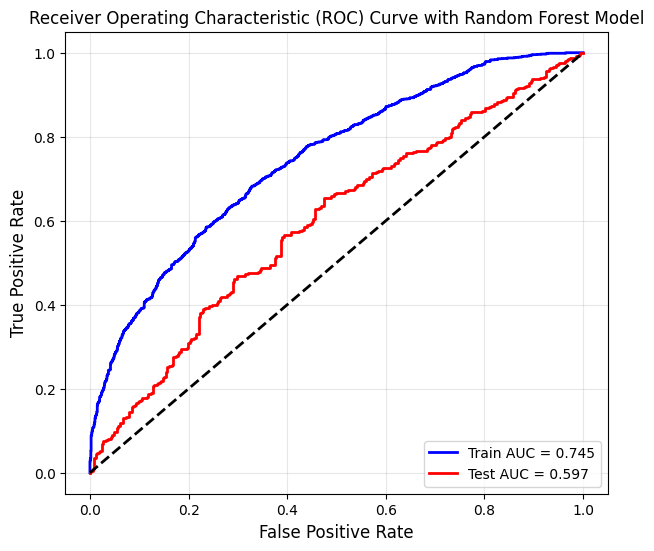

In [4]:
# 3.3 modelo RF sin las predicciones con los mismos registros
df_to_model = df_fundamental_and_target_and_predictions_cleaned.drop(columns='lstm_prediction').copy()
# Cambiar la columna target: 1 si es positiva, 0 si es negativa
df_to_model['target'] = df_to_model['target'].apply(lambda x: 1 if x > 0 else 0)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_to_model) * 0.8)  # 80% para entrenamiento
df_train = df_to_model.iloc[:train_size]  # Primer 80%
df_test = df_to_model.iloc[train_size:]   # Último 20%
X_train, X_test = df_train.drop(columns=["target"]), df_test.drop(columns=["target"])
y_train, y_test = df_train["target"], df_test["target"]


#rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=42, min_samples_split=10, min_samples_leaf=5,
                                 max_features="sqrt", bootstrap=True, class_weight="balanced_subsample")

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir las probabilidades y evaluar el rendimiento con AUC
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
nn_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]  

rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_auc_train = roc_auc_score(y_train, nn_pred_proba_train)


# Obtener curvas ROC para test y train
fpr_test, tpr_test, _ = roc_curve(y_test, rf_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, nn_pred_proba_train)

# Calcular AUC
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)



# Predecir las probabilidades
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
rf_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]  

# Convertir probabilidades a clases (0 o 1) usando un umbral de 0.5
rf_pred_test = (rf_pred_proba > 0.5).astype(int)
rf_pred_train = (rf_pred_proba_train > 0.5).astype(int)

# Calcular AUC
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_auc_train = roc_auc_score(y_train, rf_pred_proba_train)

# Calcular Accuracy
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_accuracy_train = accuracy_score(y_train, rf_pred_train)

# Imprimir resultados
print(f"Random Forest AUC test: {rf_auc}")
print(f"Random Forest AUC train: {rf_auc_train}")
print(f"Random Forest Accuracy test: {rf_accuracy_test}")
print(f"Random Forest Accuracy train: {rf_accuracy_train}")


# Graficar curvas ROC
plt.figure(figsize=(7, 6))


plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {auc_train:.3f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')



# Etiquetas y título
plt.xlabel('False Positive Rate', fontsize='large')  # Tamaño de la fuente grande para el eje x
plt.ylabel('True Positive Rate', fontsize='large')   # Tamaño de la fuente grande para el eje y
plt.title("Receiver Operating Characteristic (ROC) Curve with Random Forest Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()


In [5]:


# Obtener la matriz de confusión
rf_conf_matrix_test = confusion_matrix(y_test, rf_pred_test)
rf_conf_matrix_train = confusion_matrix(y_train, rf_pred_train)

# Imprimir la matriz de confusión
print("Matriz de confusión (Test):")
print(rf_conf_matrix_test)

print("Matriz de confusión (Train):")
print(rf_conf_matrix_train)

Matriz de confusión (Test):
[[135 196]
 [132 340]]
Matriz de confusión (Train):
[[1007  673]
 [ 401 1130]]


In [46]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo con una neurona por variable
model = keras.Sequential([
    layers.Dense(X_train.shape[1], activation="relu", input_shape=(X_train.shape[1],)),  # Capa con una neurona por feature
    layers.Dropout(0.3),  # Dropout con 30% de neuronas desactivadas
    layers.Dense(X_train.shape[1]*X_train.shape[1], activation="relu"),  # Capa oculta con 64 neuronas
    layers.Dropout(0.3),  # Otro Dropout con 30% de neuronas desactivadas
    layers.Dense(256, activation="relu"),  # Otra capa oculta con 32 neuronas
    layers.Dropout(0.3),  # Dropout en la capa oculta
    layers.Dense(1, activation="sigmoid")  # Capa de salida
])
# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()])

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test_scaled, y_test), verbose=1)

# Predicciones
nn_pred_proba_train = model.predict(X_train_scaled).flatten()
nn_pred_proba_test = model.predict(X_test_scaled).flatten()

# Calcular AUC
nn_auc_train = roc_auc_score(y_train, nn_pred_proba_train)
nn_auc_test = roc_auc_score(y_test, nn_pred_proba_test)

print(f"Neural Network AUC test: {nn_auc_test}")
print(f"Neural Network AUC train: {nn_auc_train}")

Epoch 1/10
101/101 [==============================] - 8s 60ms/step - loss: 0.7222 - auc_5: 0.5306 - val_loss: 0.7007 - val_auc_5: 0.5628
Epoch 2/10
101/101 [==============================] - 6s 58ms/step - loss: 0.6873 - auc_5: 0.5719 - val_loss: 0.6751 - val_auc_5: 0.6286
Epoch 3/10
101/101 [==============================] - 6s 59ms/step - loss: 0.6827 - auc_5: 0.5774 - val_loss: 0.7019 - val_auc_5: 0.5751
Epoch 4/10
101/101 [==============================] - 6s 57ms/step - loss: 0.6795 - auc_5: 0.5984 - val_loss: 0.6940 - val_auc_5: 0.5914
Epoch 5/10
101/101 [==============================] - 6s 58ms/step - loss: 0.6719 - auc_5: 0.6129 - val_loss: 0.7016 - val_auc_5: 0.5615
Epoch 6/10
101/101 [==============================] - 6s 56ms/step - loss: 0.6686 - auc_5: 0.6247 - val_loss: 0.7136 - val_auc_5: 0.5603
Epoch 7/10
101/101 [==============================] - 5s 54ms/step - loss: 0.6632 - auc_5: 0.6390 - val_loss: 0.7289 - val_auc_5: 0.5583
Epoch 8/10
101/101 [=====================

NEURAL NETWORK

26/26 [==============================] - 0s 7ms/step
Neural Network AUC test: 0.5548543192175738
Neural Network AUC train: 0.7289431121893565
Neural Network Accuracy test: 0.5280199252801993
Neural Network Accuracy train: 0.659919028340081


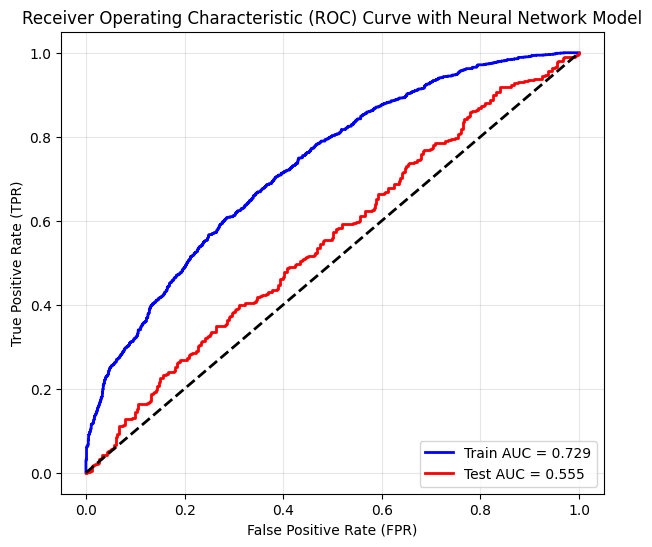

In [55]:

# Obtener las probabilidades predichas
nn_pred_proba_train = model.predict(X_train_scaled).flatten()
nn_pred_proba_test = model.predict(X_test_scaled).flatten()

# Convertir probabilidades a clases (0 o 1) usando un umbral de 0.5
nn_pred_train = (nn_pred_proba_train > 0.5).astype(int)
nn_pred_test = (nn_pred_proba_test > 0.5).astype(int)

# Calcular AUC
nn_auc_train = roc_auc_score(y_train, nn_pred_proba_train)
nn_auc_test = roc_auc_score(y_test, nn_pred_proba_test)

# Calcular Accuracy
nn_accuracy_train = accuracy_score(y_train, nn_pred_train)
nn_accuracy_test = accuracy_score(y_test, nn_pred_test)

# Imprimir resultados
print(f"Neural Network AUC test: {nn_auc_test}")
print(f"Neural Network AUC train: {nn_auc_train}")
print(f"Neural Network Accuracy test: {nn_accuracy_test}")
print(f"Neural Network Accuracy train: {nn_accuracy_train}")


# Obtener curvas ROC para test y train
fpr_test, tpr_test, _ = roc_curve(y_test, nn_pred_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train, nn_pred_proba_train)

# Calcular AUC
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

# Graficar curvas ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {auc_train:.3f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Etiquetas y título
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve with Neural Network Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

GRADIENT BOOSTING

Gradient Boosting AUC test: 0.5704945209688156
Gradient Boosting AUC train: 0.7265141441945817
Gradient Boosting Accuracy test: 0.5554171855541719
Gradient Boosting Accuracy train: 0.659919028340081


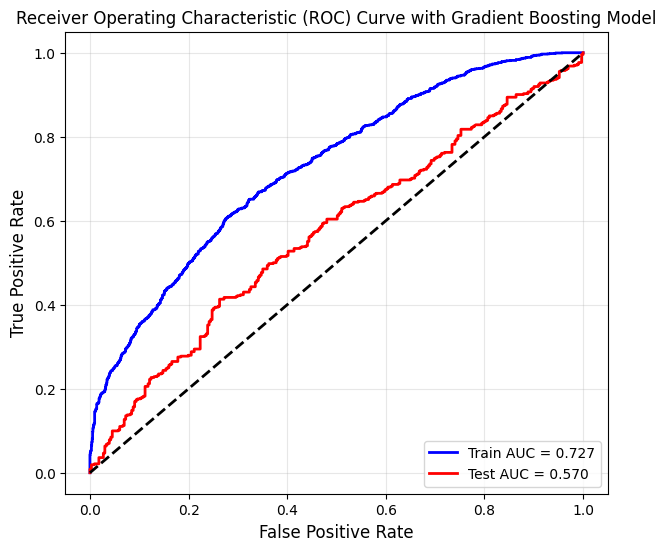

In [6]:


# 3.3 modelo Gradient Boosting sin las predicciones con los mismos registros
df_to_model = df_fundamental_and_target_and_predictions_cleaned.drop(columns='lstm_prediction').copy()
# Cambiar la columna target: 1 si es positiva, 0 si es negativa
df_to_model['target'] = df_to_model['target'].apply(lambda x: 1 if x > 0 else 0)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_to_model) * 0.8)  # 80% para entrenamiento
df_train = df_to_model.iloc[:train_size]  # Primer 80%
df_test = df_to_model.iloc[train_size:]   # Último 20%
X_train, X_test = df_train.drop(columns=["target"]), df_test.drop(columns=["target"])
y_train, y_test = df_train["target"], df_test["target"]

# Modelo Gradient Boosting ajustado
gb_model = GradientBoostingClassifier(
    n_estimators=134,  # Reducir el número de estimadores
    max_depth=3,       # Reducir la profundidad máxima de los árboles
    random_state=42, 
    min_samples_split=21,  # Aumentar min_samples_split para evitar sobreajuste
    min_samples_leaf=9,   # Aumentar min_samples_leaf para simplificar los árboles
    learning_rate=0.01,    # Reducir la tasa de aprendizaje
    subsample=0.8         # Submuestro de los datos, evitar sobreajuste
)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Predecir las clases (0 o 1) en lugar de las probabilidades para accuracy
gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)

# Calcular accuracy
accuracy_train = accuracy_score(y_train, gb_pred_train)
accuracy_test = accuracy_score(y_test, gb_pred_test)

# Predecir las probabilidades y evaluar el rendimiento con AUC
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
gb_pred_proba_train = gb_model.predict_proba(X_train)[:, 1]  

gb_auc = roc_auc_score(y_test, gb_pred_proba)
gb_auc_train = roc_auc_score(y_train, gb_pred_proba_train)

print(f"Gradient Boosting AUC test: {gb_auc}")
print(f"Gradient Boosting AUC train: {gb_auc_train}")
print(f"Gradient Boosting Accuracy test: {accuracy_test}")
print(f"Gradient Boosting Accuracy train: {accuracy_train}")

# Obtener curvas ROC para test y train
fpr_test, tpr_test, _ = roc_curve(y_test, gb_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, gb_pred_proba_train)

# Calcular AUC
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

# Graficar curvas ROC
plt.figure(figsize=(7, 6))

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {auc_train:.3f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Etiquetas y título
plt.xlabel('False Positive Rate', fontsize='large')  # Tamaño de la fuente grande para el eje x
plt.ylabel('True Positive Rate', fontsize='large')   # Tamaño de la fuente grande para el eje y
plt.title("Receiver Operating Characteristic (ROC) Curve with Gradient Boosting Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()


HYBRID MODELS WITH LSTM PREDICTIONS - ONLY RANDOM FOREST

In [4]:
# 3.3 modelo con todas las predicciones
df_to_model = df_fundamental_and_target_and_predictions_cleaned.copy()
# Cambiar la columna target: 1 si es positiva, 0 si es negativa
df_to_model['target'] = df_to_model['target'].apply(lambda x: 1 if x > 0 else 0)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_to_model) * 0.8)  # 80% para entrenamiento
df_train = df_to_model.iloc[:train_size]  # Primer 80%
df_test = df_to_model.iloc[train_size:]   # Último 20%
X_train, X_test = df_train.drop(columns=["target"]), df_test.drop(columns=["target"])
y_train, y_test = df_train["target"], df_test["target"]


#rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=42, min_samples_split=10, min_samples_leaf=5,
                                 max_features="sqrt", bootstrap=True, class_weight="balanced_subsample")

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir las probabilidades y evaluar el rendimiento con AUC
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
rf_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]  

rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_auc_train = roc_auc_score(y_train, rf_pred_proba_train)

print(f"Random Forest AUC test: {rf_auc}")
print(f"Random Forest AUC train: {rf_auc_train}")


# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame and sort by importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(importance_df.reset_index().head(50))

Random Forest AUC test: 0.5984561421475754
Random Forest AUC train: 0.7453345152561351
    index                                        Feature  Importance
0      47                                 ytd_percentage    0.059609
1      86                       dif_percentage_media_200    0.036141
2      43           potencial_precio_objetivo_percentage    0.032892
3      49                percentage_desde_minimos_1_year    0.031422
4      51                percentage_desde_maximos_1_year    0.030663
5      89                                   media_50_200    0.026204
6      79                       var_percentage_po_3meses    0.024569
7      87                        dif_percentage_media_50    0.021999
8      91  volumen_dia_3_meses_capitalizacion_percentage    0.017636
9      88                        dif_percentage_media_25    0.017153
10     71      percentage_capital_contratado_diariamente    0.016780
11     70                    three_y_beta_rel_to_loc_idx    0.016633
12     93       

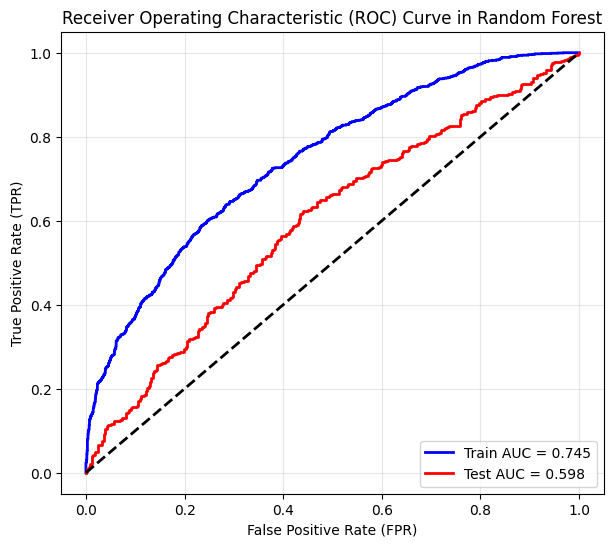

In [5]:
# Obtener curvas ROC para test y train
fpr_test, tpr_test, _ = roc_curve(y_test, rf_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, rf_pred_proba_train)

# Calcular AUC
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

# Graficar curvas ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {auc_train:.3f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Etiquetas y título
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve in Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

In [6]:
# Predecir las probabilidades
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
rf_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]  

# Convertir probabilidades a clases (0 o 1) usando un umbral de 0.5
rf_pred_test = (rf_pred_proba > 0.5).astype(int)
rf_pred_train = (rf_pred_proba_train > 0.5).astype(int)

# Calcular AUC
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_auc_train = roc_auc_score(y_train, rf_pred_proba_train)

# Calcular Accuracy
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_accuracy_train = accuracy_score(y_train, rf_pred_train)

# Imprimir resultados
print(f"Random Forest AUC test: {rf_auc}")
print(f"Random Forest AUC train: {rf_auc_train}")
print(f"Random Forest Accuracy test: {rf_accuracy_test}")
print(f"Random Forest Accuracy train: {rf_accuracy_train}")

Random Forest AUC test: 0.5984561421475754
Random Forest AUC train: 0.7453345152561351
Random Forest Accuracy test: 0.5940224159402242
Random Forest Accuracy train: 0.6633447524135784


In [7]:
# 3.4 bucle de modelos perdiendo datos filtrando por mejor AUC y obtención de gráfica.
auc_min = df_metadata.auc_test.min()
auc_max= df_metadata.auc_test.max()
print("AUC min: ", auc_min)
print("AUC max: ", auc_max)
df_auc_test = df_metadata[['ticker', 'auc_test']]
df_to_loop =  pd.merge(df_fundamental_and_target_and_predictions, df_auc_test, left_on='symbol', right_on='ticker', how='inner')

AUC min:  0.297883597883598
AUC max:  0.9272727272727274


In [8]:
df_to_loop
list_of_auc_threshold = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]


rf_auc_list = []
rf_auc_train_list = []
raw_num_list = []
threshold_list = []


for threshold in list_of_auc_threshold:
    df_to_model = df_to_loop[df_to_loop['auc_test']>threshold].drop(columns=columns_to_drop).dropna().drop(columns=['ticker', 'auc_test']).dropna()
    
    df_to_model['target'] = df_to_model['target'].apply(lambda x: 1 if x > 0 else 0)

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_to_model) * 0.8)  # 80% para entrenamiento
    df_train = df_to_model.iloc[:train_size]  # Primer 80%
    df_test = df_to_model.iloc[train_size:]   # Último 20%
    X_train, X_test = df_train.drop(columns=["target"]), df_test.drop(columns=["target"])
    y_train, y_test = df_train["target"], df_test["target"]


    #rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=42, min_samples_split=10, min_samples_leaf=5,
                                     max_features="sqrt", bootstrap=True, class_weight="balanced_subsample")

    # Entrenar el modelo
    rf_model.fit(X_train, y_train)

    # Predecir las probabilidades y evaluar el rendimiento con AUC
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
    nn_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]  

    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_auc_train = roc_auc_score(y_train, nn_pred_proba_train)
    raw_num = len(df_to_model)
    
    # Guardar valores en listas
    rf_auc_list.append(rf_auc)
    rf_auc_train_list.append(rf_auc_train)
    raw_num_list.append(raw_num)
    threshold_list.append(threshold)
    
    print(f"Number of raws: {raw_num}")
    print(f"Threshold AUC in LSTM Predictions: {threshold}")
    print(f"Random Forest AUC test: {rf_auc}")
    print(f"Random Forest AUC train: {rf_auc_train}")
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame and sort by importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the top 20 most important features
    print(importance_df.head(20))
    
    

Number of raws: 3070
Threshold AUC in LSTM Predictions: 0.3
Random Forest AUC test: 0.5900301409407369
Random Forest AUC train: 0.7544092690312307
                                          Feature  Importance
44           potencial_precio_objetivo_percentage    0.051648
87                       dif_percentage_media_200    0.047771
88                        dif_percentage_media_50    0.039918
50                percentage_desde_minimos_1_year    0.038138
52                percentage_desde_maximos_1_year    0.034809
99   evolucion_acciones_cortas_3_meses_percentage    0.031948
48                                 ytd_percentage    0.026951
80                       var_percentage_po_3meses    0.024533
90                                   media_50_200    0.022007
89                        dif_percentage_media_25    0.021710
71                    three_y_beta_rel_to_loc_idx    0.017969
32                                        peg_fy1    0.012597
100                               lstm_predicti

Number of raws: 319
Threshold AUC in LSTM Predictions: 0.6
Random Forest AUC test: 0.7330049261083743
Random Forest AUC train: 0.9462901439645626
                                          Feature  Importance
44           potencial_precio_objetivo_percentage    0.055571
50                percentage_desde_minimos_1_year    0.041611
87                       dif_percentage_media_200    0.038591
90                                   media_50_200    0.032868
100                               lstm_prediction    0.031925
80                       var_percentage_po_3meses    0.031842
52                percentage_desde_maximos_1_year    0.029579
48                                 ytd_percentage    0.025588
88                        dif_percentage_media_50    0.023486
99   evolucion_acciones_cortas_3_meses_percentage    0.023212
94           ventas_trimestre_sorpresa_percentage    0.017683
89                        dif_percentage_media_25    0.017538
93              bpa_trimestre_sorpresa_percentag

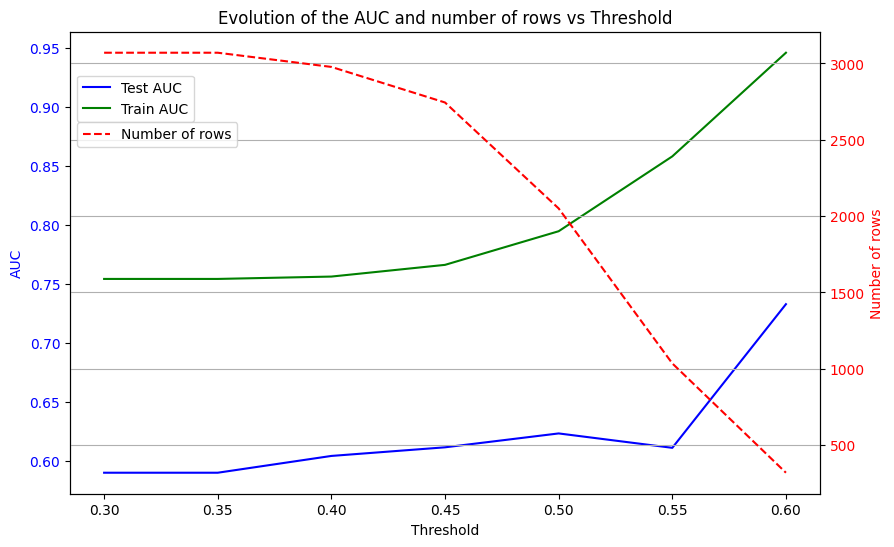

In [13]:
# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar AUC Test y AUC Train en el eje principal (izquierdo)
ax1.plot(threshold_list, rf_auc_list, label="Test AUC", color="b")
ax1.plot(threshold_list, rf_auc_train_list, label="Train AUC", color="g")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("AUC", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Crear un segundo eje Y para num_raws
ax2 = ax1.twinx()
ax2.plot(threshold_list, raw_num_list, label="Number of rows", color="r", linestyle="dashed")
ax2.set_ylabel("Number of rows", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Agregar leyendas con bbox_to_anchor para mover la leyenda izquierda hacia abajo
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.92), ncol=1)

# Agregar la leyenda de ax2 debajo de la de ax1
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.82), ncol=1)

# Título y grid
plt.title("Evolution of the AUC and number of rows vs Threshold")
plt.grid()

# Ajustar el espacio a la izquierda
fig.subplots_adjust(left=0.15)

# Mostrar la gráfica
plt.show()